# This is notebook implementing pipeline from the article

In [1]:
from data.generate_datasets import make_gravitational_waves
from pathlib import Path
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from gudhi.sklearn.rips_persistence import RipsPersistence
from gudhi.representations import DiagramSelector, Landscape
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from net import Clasificator, train
import torch.nn.functional as F
import torch 
from torch import nn

np.random.seed(42)

In [2]:
R = 0.65
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


In [3]:
# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise)))[:3500], y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background)))[:3500],
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal)))[:3500], y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()


In [4]:
class BatchModule(BaseEstimator, TransformerMixin):
    def __init__(self, module, *args, **kwargs):
        self.module = module
        self.args = args
        self.kwargs = kwargs
        self.models_ = []

    def fit(self, X, y=None):
        self.models_ = []
        for cloud in X:
            model = self.module(
                *self.args, **self.kwargs
            )
            model.fit(cloud)
            self.models_.append(model)
        return self

    def transform(self, X):
        return [model.transform(cloud) for model, cloud in zip(self.models_, X)]

In [5]:
embedding_dimension = 200
embedding_time_delay = 1
stride = 5
pipeline_embedder = Pipeline(
    [
        ("embedder", TimeDelayEmbedding(dim=embedding_dimension, delay=embedding_time_delay, skip=stride)),
        ("PCA", BatchModule(PCA, n_components=3)),
    ]
)
embedded_clouds = pipeline_embedder.fit_transform(noisy_signals)
print(embedded_clouds[0].shape)

(1699, 3)


In [6]:
from gudhi.representations.vector_methods import BettiCurve
pipeline_complex = Pipeline(
    [
        ("rips_pers", RipsPersistence(homology_dimensions=(0,1), n_jobs=-1, homology_coeff_field=2, num_collapses=0)),
        ("finite_diags", BatchModule(DiagramSelector, use=True, point_type="finite")),
        ("betti_cruve", BatchModule(BettiCurve, resolution=100)),
    ]
)


# TO DO WIĘCEJ ŚMIESZNYCH CHMUR


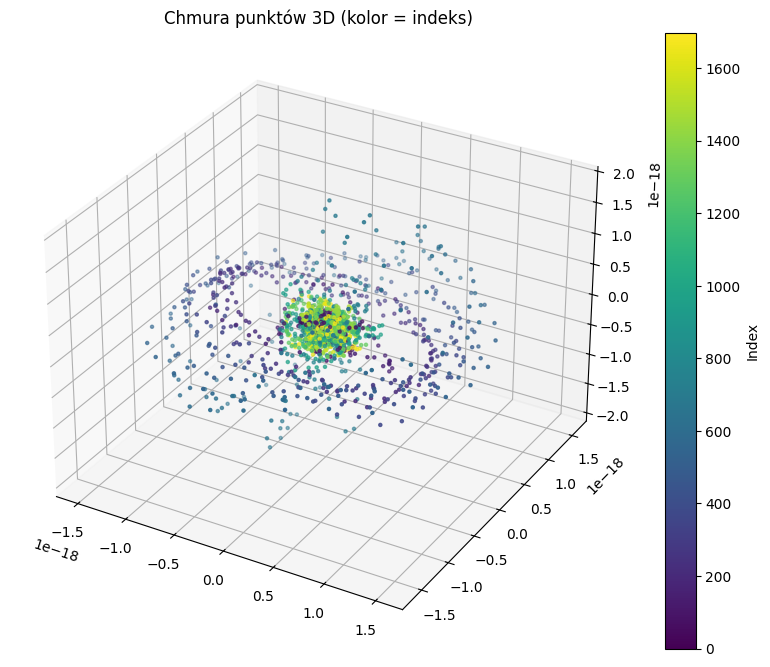

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Indeksy punktów jako kolory
points = embedded_clouds[signal_idx]
#points = embedded_clouds[background_idx]
indices = np.arange(points.shape[0])

# Rysowanie
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                c=indices, cmap='viridis', s=5)

plt.colorbar(sc, ax=ax, label='Index')
ax.set_title('Chmura punktów 3D (kolor = indeks)')
plt.show()

# Train neural network 

In [11]:
class GravWavesDataSet(Dataset): 
    def __init__(self, noise_signal, labels): 
        self.noise_signal = noise_signal
        self.labels = labels
        self.betti_curves = pipeline_complex.fit_transform(
            pipeline_embedder.fit_transform(
                self.noise_signal
                )
            )
        
    def __len__(self): 
        return len(self.noise_signal)

    def _transform(self, data): 
        data = torch.Tensor(data)

        mean = data.mean()
        std = data.std()
        data = (data - mean) / (std + 1e-8) 

        if len(data.shape) == 1:
            data = data.unsqueeze(0)
            
        return data 

    def __getitem__(self, idx): 
        signal = self._transform(self.noise_signal[idx])
        betti = self._transform(self.betti_curves[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return (signal, betti), label
    
X_train, X_test, y_train, y_test = train_test_split(
    np.array(noisy_signals), np.array(labels), test_size=0.1, random_state=42, stratify=labels
) 

train_dataset = GravWavesDataSet(X_train, y_train)
test_dataset = GravWavesDataSet(X_test, y_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = Clasificator()
optim = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

train(model, device, train_loader, test_loader, optim, epochs=40)


singal_embedded torch.Size([32, 1792])
Train Epoch: 1 [0/90 (0%)]	Loss: 0.718410
singal_embedded torch.Size([32, 1792])
singal_embedded torch.Size([26, 1792])
singal_embedded torch.Size([10, 1792])

Test set: Average loss: 0.0688, Accuracy: 6/10 (60%)

singal_embedded torch.Size([32, 1792])
Train Epoch: 2 [0/90 (0%)]	Loss: 0.680209
singal_embedded torch.Size([32, 1792])
singal_embedded torch.Size([26, 1792])
singal_embedded torch.Size([10, 1792])

Test set: Average loss: 0.0675, Accuracy: 6/10 (60%)

singal_embedded torch.Size([32, 1792])
Train Epoch: 3 [0/90 (0%)]	Loss: 0.693911
singal_embedded torch.Size([32, 1792])
singal_embedded torch.Size([26, 1792])
singal_embedded torch.Size([10, 1792])

Test set: Average loss: 0.0673, Accuracy: 6/10 (60%)

singal_embedded torch.Size([32, 1792])
Train Epoch: 4 [0/90 (0%)]	Loss: 0.652324
singal_embedded torch.Size([32, 1792])
singal_embedded torch.Size([26, 1792])
singal_embedded torch.Size([10, 1792])

Test set: Average loss: 0.0678, Accuracy:

In [15]:
model = Clasificator(with_betti=False)
optim = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(model, device, train_loader, test_loader, optim, epochs=40)

singal_embedded torch.Size([32, 1792])
Train Epoch: 1 [0/90 (0%)]	Loss: 0.693150
singal_embedded torch.Size([32, 1792])
singal_embedded torch.Size([26, 1792])
singal_embedded torch.Size([10, 1792])

Test set: Average loss: 0.0689, Accuracy: 6/10 (60%)

singal_embedded torch.Size([32, 1792])
Train Epoch: 2 [0/90 (0%)]	Loss: 0.687349
singal_embedded torch.Size([32, 1792])
singal_embedded torch.Size([26, 1792])
singal_embedded torch.Size([10, 1792])

Test set: Average loss: 0.0678, Accuracy: 6/10 (60%)

singal_embedded torch.Size([32, 1792])
Train Epoch: 3 [0/90 (0%)]	Loss: 0.685616
singal_embedded torch.Size([32, 1792])
singal_embedded torch.Size([26, 1792])
singal_embedded torch.Size([10, 1792])

Test set: Average loss: 0.0680, Accuracy: 6/10 (60%)

singal_embedded torch.Size([32, 1792])
Train Epoch: 4 [0/90 (0%)]	Loss: 0.583107
singal_embedded torch.Size([32, 1792])
singal_embedded torch.Size([26, 1792])
singal_embedded torch.Size([10, 1792])

Test set: Average loss: 0.0683, Accuracy: 